## Imports

In [1]:
import sys
import json
import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.ndimage import binary_erosion, binary_dilation

In [2]:
sys.path.append(r"C:\\Users\\97254\\Desktop\\git\\MS2")

In [3]:
from cell_tracking import get_masks_paths
from src.utils.gif_utils import create_gif_from_figures
from src.utils.image_utils import enhance_cell_image_contrast

## Functions

In [4]:
# Visualization utilities
def cluster_mask_overlay(
    masks: np.ndarray,
    clustered_cells_df: pd.DataFrame,
    tracklets: dict,
    timepoint: int,
    rng_seed: int = 0,
    base_image: np.ndarray | None = None,
    overlay_alpha: float = 0.6,
    background_color=(0, 0, 0),
    out_dtype=np.uint8,
    cluster_name_map: dict = None,
    fixed_colors: dict = None
):
    """
    Return an RGB image made by overlaying each cluster's cells over a base image.

    If base_image is None, the overlay is drawn on a solid background_color.

    Parameters
    ----------
    masks : np.ndarray
        2D (H,W) or 3D (Z,H,W) labeled mask(s).
    clustered_cells_df : pd.DataFrame
        Columns: ['cell', 'cluster'].
    tracklets : dict
        tracklets[track_id][timepoint] -> label in masks for that cell at timepoint.
    timepoint : int
        Time index.
    rng_seed : int
        Seed for random colors (used for clusters not in fixed_colors).
    base_image : np.ndarray | None
        Grayscale (H,W) or RGB (H,W,3) image to blend underneath the cluster colors.
    overlay_alpha : float
        Opacity of the cluster color in [0,1]. 0=transparent, 1=opaque.
    background_color : tuple
        Used only if base_image is None.
    out_dtype : numpy dtype
        Output dtype (default uint8).
    cluster_name_map : dict | None
        Map cluster id -> human-readable name.

    Fixed colors:
        0 -> dark gray
        1 -> white
        2 -> yellow
        3 -> red

    Returns
    -------
    img : (H,W,3) array
        RGB image with clusters blended over the base image.
    cluster_colors : dict {cluster_id: (r,g,b)}
    cluster_labels : dict {cluster_id: str}
    """
    if cluster_name_map is None:
        cluster_name_map = {
            0: "non active cells",
            1: "shortly active",
            2: "highly active",
            3: "moderate active",
            4: "weakly active",
        }
    if fixed_colors is None:
        fixed_colors = {
            0: (64, 64, 64),      # dark gray
            1: (255, 0, 0),       # red
            2: (255, 255, 255),   # white
            3: (255, 255, 0),     # yellow
            4: (255, 165, 0),     # orange
        }

    if masks.ndim == 2:
        vol = masks[None, ...]
    elif masks.ndim == 3:
        vol = masks
    else:
        raise ValueError("masks must be 2D or 3D")

    _, H, W = vol.shape

    # Prepare base RGB image (either from base_image or solid background)
    def to_uint8_rgb(img: np.ndarray) -> np.ndarray:
        # Validate spatial size
        if img.ndim == 2:
            if img.shape != (H, W):
                raise ValueError(f"base_image shape {img.shape} must match (H,W)=({H},{W})")
            rgb = np.stack([img, img, img], axis=-1)
        elif img.ndim == 3 and img.shape[-1] == 3:
            if img.shape[:2] != (H, W):
                raise ValueError(f"base_image shape {img.shape[:2]} must match (H,W)=({H},{W})")
            rgb = img
        else:
            raise ValueError("base_image must be 2D (H,W) or 3D (H,W,3)")

        if rgb.dtype == np.uint8:
            return rgb.copy()

        if np.issubdtype(rgb.dtype, np.floating):
            mx = float(np.nanmax(rgb)) if np.isfinite(rgb).any() else 0.0
            if mx <= 1.0:
                rgb = (np.clip(rgb, 0.0, 1.0) * 255.0).astype(np.uint8)
            else:
                rgb = np.clip(rgb, 0.0, 255.0).astype(np.uint8)
            return rgb

        # e.g., uint16 or other integer types
        mx = float(rgb.max()) if rgb.size > 0 else 0.0
        if mx > 0:
            rgb = (rgb.astype(np.float32) * (255.0 / mx)).clip(0, 255).astype(np.uint8)
        else:
            rgb = np.zeros_like(rgb, dtype=np.uint8)
        return rgb

    if base_image is None:
        base_rgb = np.empty((H, W, 3), dtype=np.uint8)
        base_rgb[:] = np.array(background_color, dtype=np.uint8)
    else:
        base_rgb = to_uint8_rgb(base_image)

    # Clamp alpha
    overlay_alpha = float(np.clip(overlay_alpha, 0.0, 1.0))

    rng = np.random.default_rng(rng_seed)
    cluster_ids = clustered_cells_df['cluster'].unique()
    cluster_colors: dict[int, tuple[int, int, int]] = {}
    cluster_labels: dict[int, str] = {}

    # cell -> cluster map
    cell_to_cluster = {}
    for _, row in clustered_cells_df.iterrows():
        cell_name = str(row['cell'])
        if cell_name.startswith('cell_'):
            cell_name = cell_name[5:]
        cell_to_cluster[cell_name] = row['cluster']

    # collect labels in masks per cluster
    cluster_to_labels = {cid: [] for cid in cluster_ids}
    for track_id, track in tracklets.items():
        cid = cell_to_cluster.get(str(track_id))
        if cid is None:
            continue
        if timepoint >= len(track):
            continue
        lab = track[timepoint]
        if lab is None or lab == 0:
            continue
        cluster_to_labels[cid].append(lab)

    # Prepare overlay color buffer and a combined mask
    overlay_rgb = np.zeros((H, W, 3), dtype=np.uint8)
    any_mask = np.zeros((H, W), dtype=bool)

    # paint clusters into overlay_rgb
    for cid in cluster_ids:
        labels = list({l for l in cluster_to_labels[cid] if l != 0})
        if not labels:
            continue
        color = fixed_colors.get(cid, tuple(rng.integers(0, 256, size=3).tolist()))
        cluster_colors[cid] = color
        cluster_labels[cid] = cluster_name_map.get(cid, f"Cluster {cid}")
        mask_bool = np.isin(vol, labels).any(axis=0)  # (H, W)
        if np.any(mask_bool):
            overlay_rgb[mask_bool] = np.array(color, dtype=np.uint8)
            any_mask |= mask_bool

    # Blend overlay over base image
    img = base_rgb.astype(np.float32)
    if np.any(any_mask):
        m = any_mask
        img[m] = (1.0 - overlay_alpha) * img[m] + overlay_alpha * overlay_rgb[m].astype(np.float32)
    img = img.clip(0, 255).astype(out_dtype)

    return img, cluster_colors, cluster_labels



def build_cluster_contour_overlay(
    masks: np.ndarray,
    clustered_cells_df: pd.DataFrame,
    tracklets: dict,
    timepoint: int,
    rng_seed: int = 0,
    base_image: np.ndarray | None = None,
    contour_thickness: int = 1,
    overlay_alpha: float = 1.0,
    background_color=(0, 0, 0),
    out_dtype=np.uint8,
    cluster_name_map: dict = None,
    fixed_colors: dict = None
):
    """
    Draw colored contours (outlines) for each cluster over a base image.

    If base_image is None, contours are drawn over a solid background_color.

    Parameters
    ----------
    masks : np.ndarray
        2D (H,W) or 3D (Z,H,W) labeled mask(s).
    clustered_cells_df : pd.DataFrame
        Columns: ['cell', 'cluster'].
    tracklets : dict
        tracklets[track_id][timepoint] -> label in masks for that cell at timepoint.
    timepoint : int
        Time index.
    rng_seed : int
        Seed for random colors (used for clusters not in fixed_colors).
    base_image : np.ndarray | None
        Grayscale (H,W) or RGB (H,W,3) image to draw under the contours.
    contour_thickness : int
        Approximate thickness of the contour in pixels (>=1).
    overlay_alpha : float
        Alpha for contour color in [0,1]. 1.0 replaces the underlying pixel.
    background_color : tuple
        Used only if base_image is None.
    out_dtype : numpy dtype
        Output dtype (default uint8).
    cluster_name_map : dict | None
        Map cluster id -> human-readable name.

    Fixed colors:
        0 -> dark gray, 1 -> white, 2 -> yellow, 3 -> red

    Returns
    -------
    img : (H,W,3) array
        RGB image with cluster contours.
    cluster_colors : dict {cluster_id: (r,g,b)}
    cluster_labels : dict {cluster_id: str}
    """
    if cluster_name_map is None:
        cluster_name_map = {
            0: "non active cells",
            1: "highly active",
            2: "moderate active",
            3: "weakly active",
        }
    if fixed_colors is None:
        fixed_colors = {
            0: (64, 64, 64),      # dark gray
            1: (255, 255, 255),   # white
            2: (255, 255, 0),     # yellow
            3: (255, 0, 0),       # red
        }

    if masks.ndim == 2:
        vol = masks[None, ...]
    elif masks.ndim == 3:
        vol = masks
    else:
        raise ValueError("masks must be 2D or 3D")

    _, H, W = vol.shape

    # Prepare base RGB
    def to_uint8_rgb(img: np.ndarray) -> np.ndarray:
        if img.ndim == 2:
            if img.shape != (H, W):
                raise ValueError(f"base_image shape {img.shape} must match (H,W)=({H},{W})")
            rgb = np.stack([img, img, img], axis=-1)
        elif img.ndim == 3 and img.shape[-1] == 3:
            if img.shape[:2] != (H, W):
                raise ValueError(f"base_image shape {img.shape[:2]} must match (H,W)=({H},{W})")
            rgb = img
        else:
            raise ValueError("base_image must be 2D (H,W) or 3D (H,W,3)")

        if rgb.dtype == np.uint8:
            return rgb.copy()
        if np.issubdtype(rgb.dtype, np.floating):
            mx = float(np.nanmax(rgb)) if np.isfinite(rgb).any() else 0.0
            if mx <= 1.0:
                return (np.clip(rgb, 0.0, 1.0) * 255.0).astype(np.uint8)
            return np.clip(rgb, 0.0, 255.0).astype(np.uint8)
        mx = float(rgb.max()) if rgb.size > 0 else 0.0
        if mx > 0:
            return (rgb.astype(np.float32) * (255.0 / mx)).clip(0, 255).astype(np.uint8)
        return np.zeros_like(rgb, dtype=np.uint8)

    if base_image is None:
        base_rgb = np.empty((H, W, 3), dtype=np.uint8)
        base_rgb[:] = np.array(background_color, dtype=np.uint8)
    else:
        base_rgb = to_uint8_rgb(base_image)

    overlay_alpha = float(np.clip(overlay_alpha, 0.0, 1.0))
    contour_thickness = max(1, int(contour_thickness))

    rng = np.random.default_rng(rng_seed)
    cluster_ids = clustered_cells_df['cluster'].unique()
    cluster_colors: dict[int, tuple[int, int, int]] = {}
    cluster_labels: dict[int, str] = {}

    # cell -> cluster
    cell_to_cluster = {}
    for _, row in clustered_cells_df.iterrows():
        cell_name = str(row['cell'])
        if cell_name.startswith('cell_'):
            cell_name = cell_name[5:]
        cell_to_cluster[cell_name] = row['cluster']

    # labels per cluster
    cluster_to_labels = {cid: [] for cid in cluster_ids}
    for track_id, track in tracklets.items():
        cid = cell_to_cluster.get(str(track_id))
        if cid is None or timepoint >= len(track):
            continue
        lab = track[timepoint]
        if lab is None or lab == 0:
            continue
        cluster_to_labels[cid].append(lab)

    # Helpers to compute contours without external deps
    def shift_bool(m: np.ndarray, dy: int, dx: int) -> np.ndarray:
        out = np.zeros_like(m, dtype=bool)
        y0s = max(0, -dy); y0e = m.shape[0] - max(0, dy)
        x0s = max(0, -dx); x0e = m.shape[1] - max(0, dx)
        yds = max(0, dy); yde = yds + (y0e - y0s)
        xds = max(0, dx); xde = xds + (x0e - x0s)
        if y0e > y0s and x0e > x0s:
            out[yds:yde, xds:xde] = m[y0s:y0e, x0s:x0e]
        return out

    def contour_from_mask(m: np.ndarray, thickness: int) -> np.ndarray:
        # 4-neighborhood interior test
        up = shift_bool(m, -1, 0)
        down = shift_bool(m, 1, 0)
        left = shift_bool(m, 0, -1)
        right = shift_bool(m, 0, 1)
        interior = m & up & down & left & right
        boundary = m & (~interior)

        if thickness <= 1:
            return boundary

        # Thicken boundary by OR-ing shifted copies (no wrap-around)
        thick = boundary.copy()
        for r in range(1, thickness):
            for dy, dx in [(-r, 0), (r, 0), (0, -r), (0, r),
                           (-r, -r), (-r, r), (r, -r), (r, r)]:
                thick |= shift_bool(boundary, dy, dx)
        return thick

    # Start from base
    img = base_rgb.astype(np.float32)

    # Draw contours per cluster
    for cid in cluster_ids:
        labels = list({l for l in cluster_to_labels[cid] if l != 0})
        if not labels:
            continue
        color = fixed_colors.get(cid, tuple(rng.integers(0, 256, size=3).tolist()))
        cluster_colors[cid] = color
        cluster_labels[cid] = cluster_name_map.get(cid, f"Cluster {cid}")
        c = np.array(color, dtype=np.float32)
        for label in labels:
            cell_stack = (vol == label)
            proj = cell_stack.max(axis=0)  # 2D projection of this cell
            if not proj.any():
                continue
            eroded = binary_erosion(proj, iterations=1, border_value=0)
            outline = proj ^ eroded
            if contour_thickness > 1:
                outline = binary_dilation(outline, iterations=contour_thickness - 1)
            contour = outline
            if overlay_alpha >= 1.0:
                img[contour] = c
            else:
                img[contour] = (1.0 - overlay_alpha) * img[contour] + overlay_alpha * c
    img = img.clip(0, 255).astype(out_dtype)
    return img, cluster_colors, cluster_labels


In [5]:
def show_clustered_heat_map(labels, cells_array, cell_names, heatmap_robust=True, save_eps=False, filename=None):
    order = np.argsort(labels)
    cells_sorted = cells_array[order]
    labels_sorted = labels[order]
    cell_names_sorted = [cell_names[i] for i in order]

    # Find boundaries between clusters for horizontal separator lines
    boundary_rows = np.where(np.diff(labels_sorted) != 0)[0] + 1
    unique_labels = np.unique(labels_sorted)

    # Color palette for clusters
    palette = sns.color_palette("tab10", n_colors=unique_labels.size)
    label_to_color = {lab: palette[i] for i, lab in enumerate(unique_labels)}
    row_colors = [label_to_color[l] for l in labels_sorted]

    # Plot heatmap with an auxiliary color bar for clusters
    fig = plt.figure(figsize=(20,20))
    gs = fig.add_gridspec(1, 2, width_ratios=[20, 0.6], wspace=0.05)

    ax_hm = fig.add_subplot(gs[0, 0])
    sns.heatmap(
        cells_sorted,
        cmap="viridis",
        ax=ax_hm,
        robust=heatmap_robust,
        # set to cell_names_sorted if you want all labels (may be long)
        yticklabels=False
    )

    # Add horizontal lines to separate clusters
    for br in boundary_rows:
        ax_hm.axhline(br, color='red', lw=2.0)

    ax_hm.set_title("Gene Expression Heatmap (rows grouped by cluster)")
    ax_hm.set_xlabel("Timepoint index")
    ax_hm.set_ylabel("Cells (sorted)")


    plt.tight_layout()
    # Save as EPS if requested
    if save_eps:
        if filename is None:
            filename = "clustered_heatmap.eps"
        elif not filename.endswith('.eps'):
            filename += '.eps'
        
        plt.savefig(filename, format='eps', bbox_inches='tight', dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()
    return pd.DataFrame({"cell": cell_names_sorted,"cluster": labels_sorted})

In [6]:
def get_uniform_rows(matrix):
    """
    Return rows of a 2D matrix where all values in each row are the same.
    
    Parameters
    ----------
    matrix : array-like
        2D array or matrix to check for uniform rows
        
    Returns
    -------
    uniform_rows : np.ndarray
        2D array containing only the rows where all values are identical
    row_indices : np.ndarray
        Array of indices indicating which rows from the original matrix are uniform
    """
    matrix = np.array(matrix)
    
    if matrix.ndim != 2:
        raise ValueError("Input must be a 2D matrix")
    
    # Check if all values in each row are the same
    # Compare each element with the first element of its row
    uniform_mask = np.all(matrix == matrix[:, 0:1], axis=1)
    
    # Get the uniform rows and their indices
    uniform_rows = matrix[uniform_mask]
    row_indices = np.where(uniform_mask)[0]
    
    return uniform_rows, row_indices

## Inputs

In [7]:
video_name = 'gRNA2_12.03.25-st-13-II'
tracklet_length = 1

In [8]:
csv_path = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\outputs\\gRNA2\\{video_name}\\v3p3_bug_fix\\gene_expression_results.csv'
tracklets_path = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\outputs\\gRNA2\\{video_name}\\tracklets_matching_iou_v2.json'
masks_dir = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\outputs\\gRNA2\\{video_name}\\masks'

In [9]:
df = pd.read_csv(csv_path)

In [10]:
df.head()

,timepoint,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_582,cell_586,cell_594,cell_595,cell_597,cell_615,cell_616,cell_630,cell_631,cell_632
0,0,59.0,52.0,0.0,0.0,0.0,83.0,102.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,53.0,49.0,0.0,20.0,0.0,51.0,158.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,56.0,38.0,0.0,34.0,0.0,0.0,140.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,59.0,95.5,0.0,0.0,0.0,42.0,144.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,76.0,59.0,0.0,0.0,0.0,0.0,74.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
with open(tracklets_path, 'r') as f:
        tracklets = json.load(f)

In [12]:
masks_paths = get_masks_paths(masks_dir)

## Gene Visualization

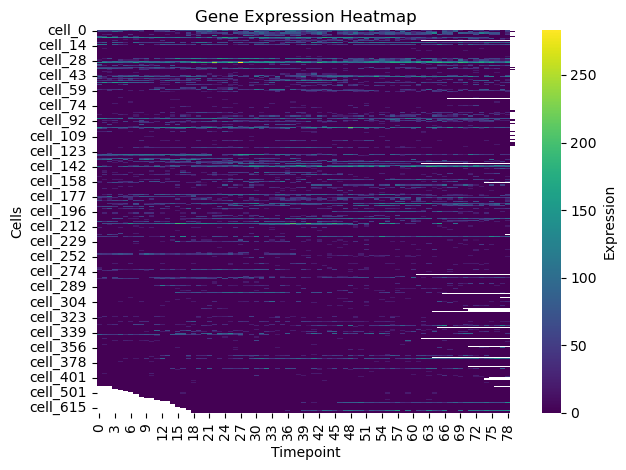

In [13]:
data = df.sort_values('timepoint').set_index('timepoint')

# Flip axes: rows=cells, columns=timepoints
plt.figure()
sns.heatmap(data.T, cmap="viridis",
            cbar_kws={"label": "Expression"})
plt.title("Gene Expression Heatmap")
plt.xlabel("Timepoint")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

In [14]:
num = df.drop(columns=['timepoint'], errors='ignore').select_dtypes(
    include=np.number)
min_non_zero = num.where(num > 0).min()  # per-column min of values > 0
min_non_zero

cell_0      21.0
cell_1      18.0
cell_2      19.0
cell_3      17.0
cell_4      21.0
            ... 
cell_615     NaN
cell_616     NaN
cell_630    20.5
cell_631     NaN
cell_632     NaN
Length: 355, dtype: float64

In [15]:
np.nanmean(min_non_zero), np.nanmedian(min_non_zero)

(18.026066350710902, 17.0)

In [16]:
nan_counts = df.drop(columns=['timepoint'], errors='ignore').isna().sum()
cols_gt1_nan = nan_counts[nan_counts > 40].index.tolist()
cols_gt1_nan  # list of column names with >1 NaN
df_filtered = df.drop(columns=cols_gt1_nan)

In [17]:
len(df.columns)

356

In [18]:
len(df_filtered.columns)

356

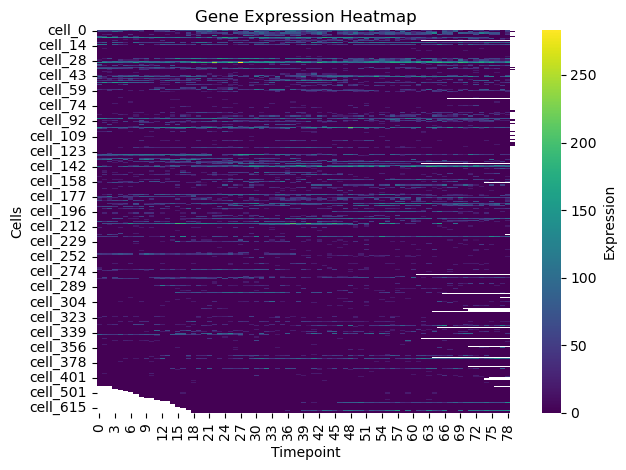

In [19]:
filtered_data = df_filtered.sort_values('timepoint').set_index('timepoint')

# Flip axes: rows=cells, columns=timepoints
plt.figure()
sns.heatmap(filtered_data.T, cmap="viridis", 
            cbar_kws={"label": "Expression"})
plt.title("Gene Expression Heatmap")
plt.xlabel("Timepoint")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

### Gene Clustering

In [20]:
df_filled = df.fillna(0.0)

In [21]:
cells_array = df_filled.drop(
    columns=['timepoint'], errors='ignore').to_numpy()[:-1, :].T

In [22]:
cell_names = df_filled.drop(
    columns=['timepoint'], errors='ignore').columns.tolist()
assert len(
    cell_names) == cells_array.shape[0], "Mismatch between cell names and cells_array rows"

In [23]:
def normalise_signals(cells_array, noise = 20):
    cells_array[cells_array < noise] = noise
    cells_array = cells_array - noise
    return (cells_array - np.min(cells_array)) / np.max(cells_array)

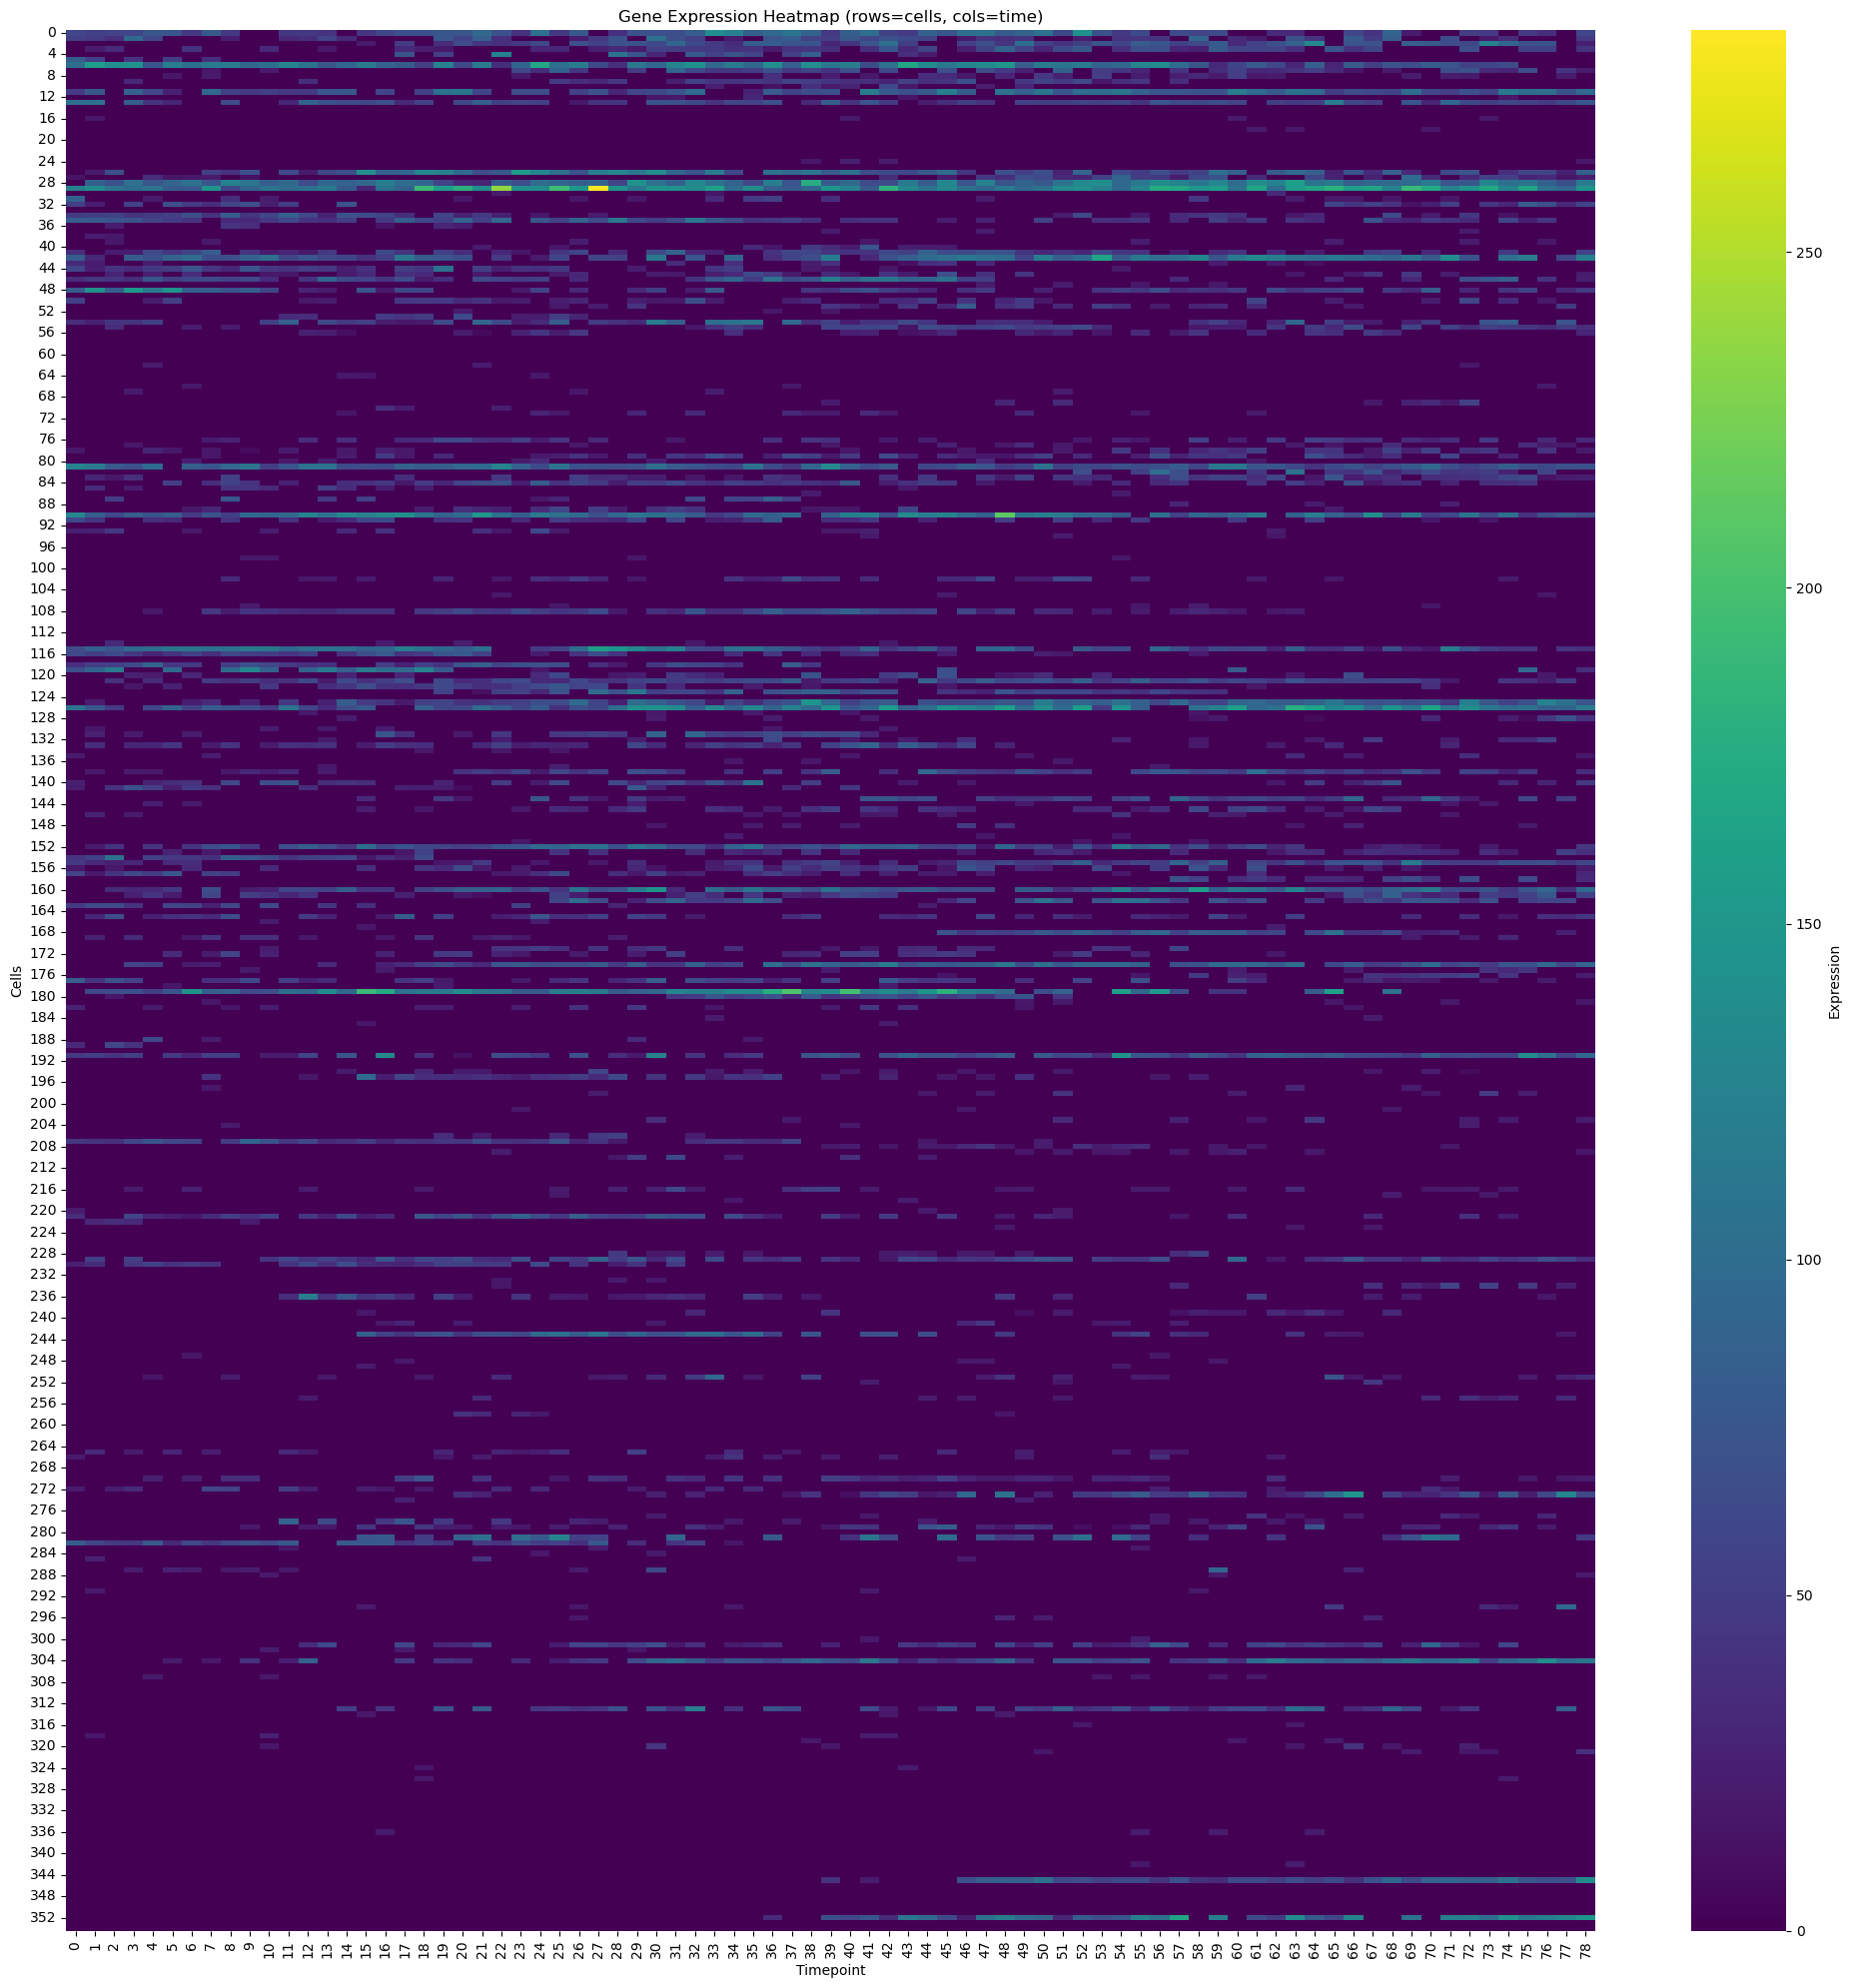

In [24]:
plt.figure(figsize=(20,20))
sns.heatmap(cells_array, cmap="viridis",
            cbar_kws={"label": "Expression"})
plt.title("Gene Expression Heatmap (rows=cells, cols=time)")
plt.xlabel("Timepoint")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

In [25]:
normalized_array = normalise_signals(cells_array, 20.0)

#### PCA K means 

In [26]:
pca = PCA(n_components='mle', svd_solver='full')
Z = pca.fit_transform(normalized_array)
components = pca.components_
explained = pca.explained_variance_ratio_

In [27]:
Z.shape, components.shape, explained.shape

((355, 73), (73, 79), (73,))

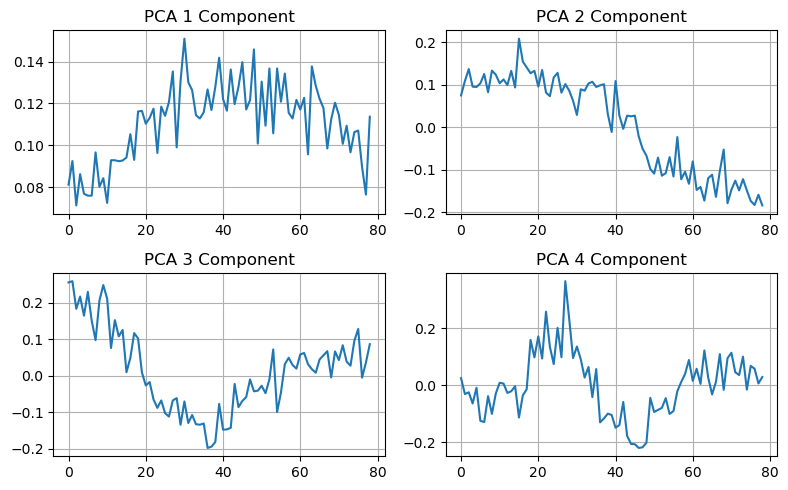

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax[0, 0].plot(components[0], label=f'PCA1')
ax[0, 0].set_title("PCA 1 Component")
ax[0, 1].plot(components[1], label=f'PCA2')
ax[0, 1].set_title("PCA 2 Component")
ax[1, 0].plot(components[2], label=f'PCA3')
ax[1, 0].set_title("PCA 3 Component")
ax[1, 1].plot(components[3], label=f'PCA4')
ax[1, 1].set_title("PCA 4 Component")
ax[0, 0].grid(True)
ax[0, 1].grid(True)
ax[1, 0].grid(True)
ax[1, 1].grid(True)
plt.tight_layout()
plt.show()

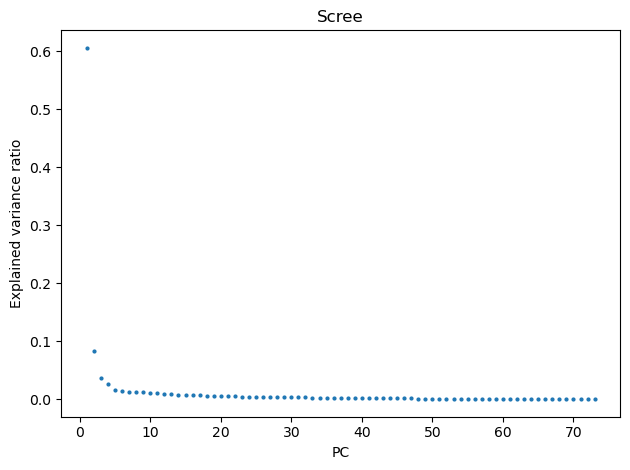

In [29]:
plt.scatter(np.arange(1, len(explained)+1), explained, marker='o', s=4)
plt.xlabel('PC')
plt.ylabel('Explained variance ratio')
plt.title('Scree')
plt.tight_layout()
plt.show()

In [30]:
labels = KMeans(n_clusters=4, random_state=0).fit_predict(Z[:, :6])

c:\Users\97254\anaconda3\envs\ms2_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [31]:
np.unique(labels)

array([0, 1, 2, 3])

C:\Users\97254\AppData\Local\Temp\ipykernel_17940\2358781790.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


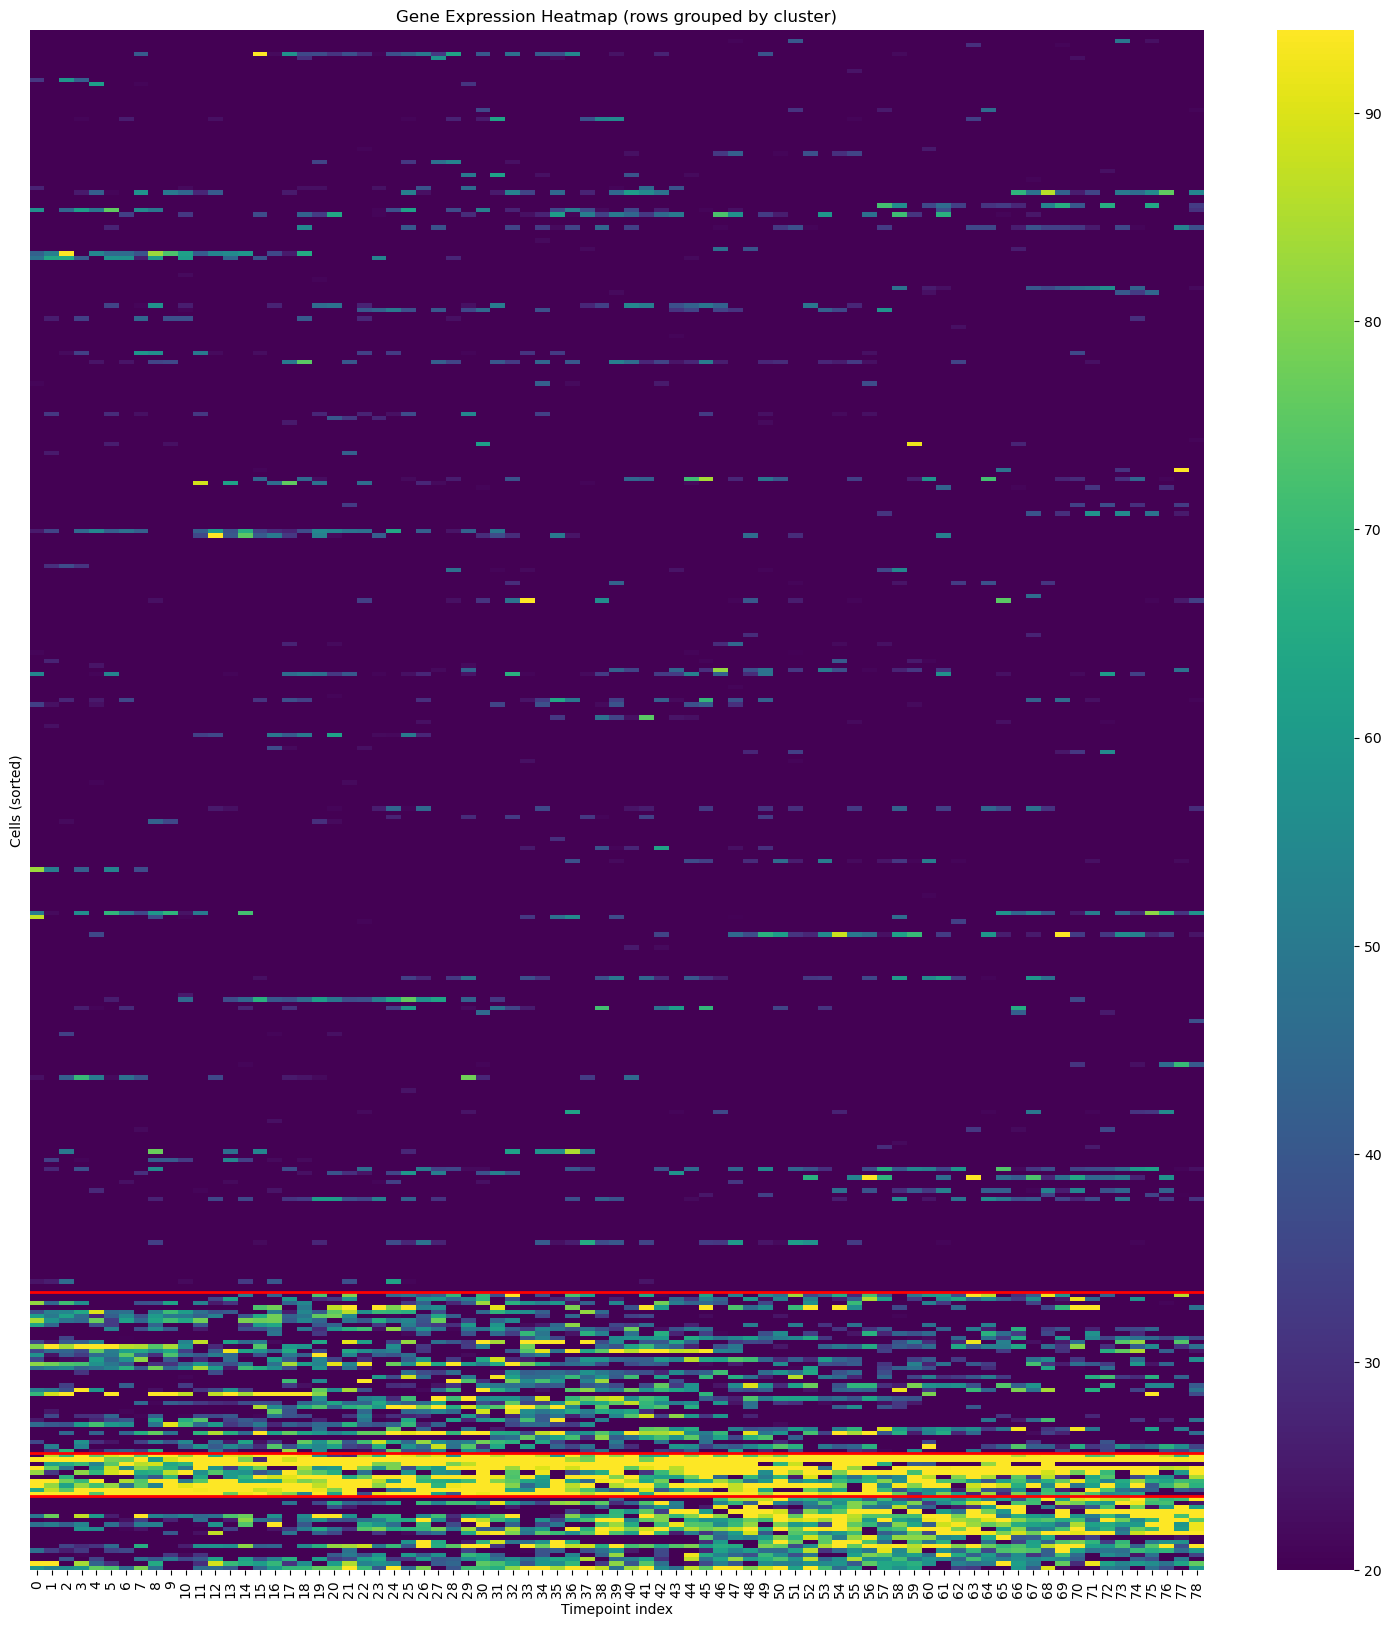

In [32]:
clustered_cells_df = show_clustered_heat_map(labels, cells_array, cell_names, True)

In [33]:
labels = labels + 1  # make labels 1-based
labels

array([4, 2, 4, 2, 2, 1, 3, 2, 1, 2, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 3, 1,
       2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 1,
       1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 3, 2, 1, 2, 2, 1, 4, 1, 2, 1, 4, 3, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 4, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1,
       1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [34]:
pos = np.where(labels == 1)[0]
pos

array([  5,   8,  10,  12,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  27,  30,  31,  32,  33,  36,  37,  38,  39,  40,
        43,  45,  47,  49,  50,  51,  52,  53,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  80,  82,  83,  85,  86,  87,  88,  89,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 109, 110, 111, 112, 113, 114, 117, 120, 122, 124,
       127, 128, 129, 130, 132, 134, 135, 136, 137, 139, 141, 142, 144,
       145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 158, 159,
       161, 163, 164, 166, 167, 169, 170, 171, 172, 173, 175, 176, 178,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222,
       223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 23

In [35]:
labels_secondary = KMeans(n_clusters=2, random_state=0).fit_predict(Z[pos, :6])
labels_secondary

c:\Users\97254\anaconda3\envs\ms2_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [36]:
pos1 = np.where(labels_secondary == 1)[0]
change_label_pos = pos[pos1]

In [37]:
labels[change_label_pos] = 0  # Change to cluster 0

In [38]:
labels

array([4, 2, 4, 2, 2, 1, 3, 2, 1, 2, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 0, 3, 3, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 3, 1,
       2, 0, 2, 1, 2, 1, 0, 0, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 3, 0, 0, 2, 1, 1, 0,
       1, 0, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 3, 2, 1, 2, 2, 0, 4, 0, 2, 1, 4, 3, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 4, 1, 2, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0,
       0, 4, 0, 0, 0, 1, 4, 0, 4, 0, 1, 2, 1, 1, 4, 1, 1, 0, 0, 1, 4, 1,
       1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 4, 1, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [39]:
labels_swapped = np.where(labels == 1, 0,
                  np.where(labels == 0, 1, labels))

In [40]:
np.unique(labels_swapped)

array([0, 1, 2, 3, 4])

C:\Users\97254\AppData\Local\Temp\ipykernel_17940\2358781790.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Figure saved as clustered_heatmap_swapped.eps


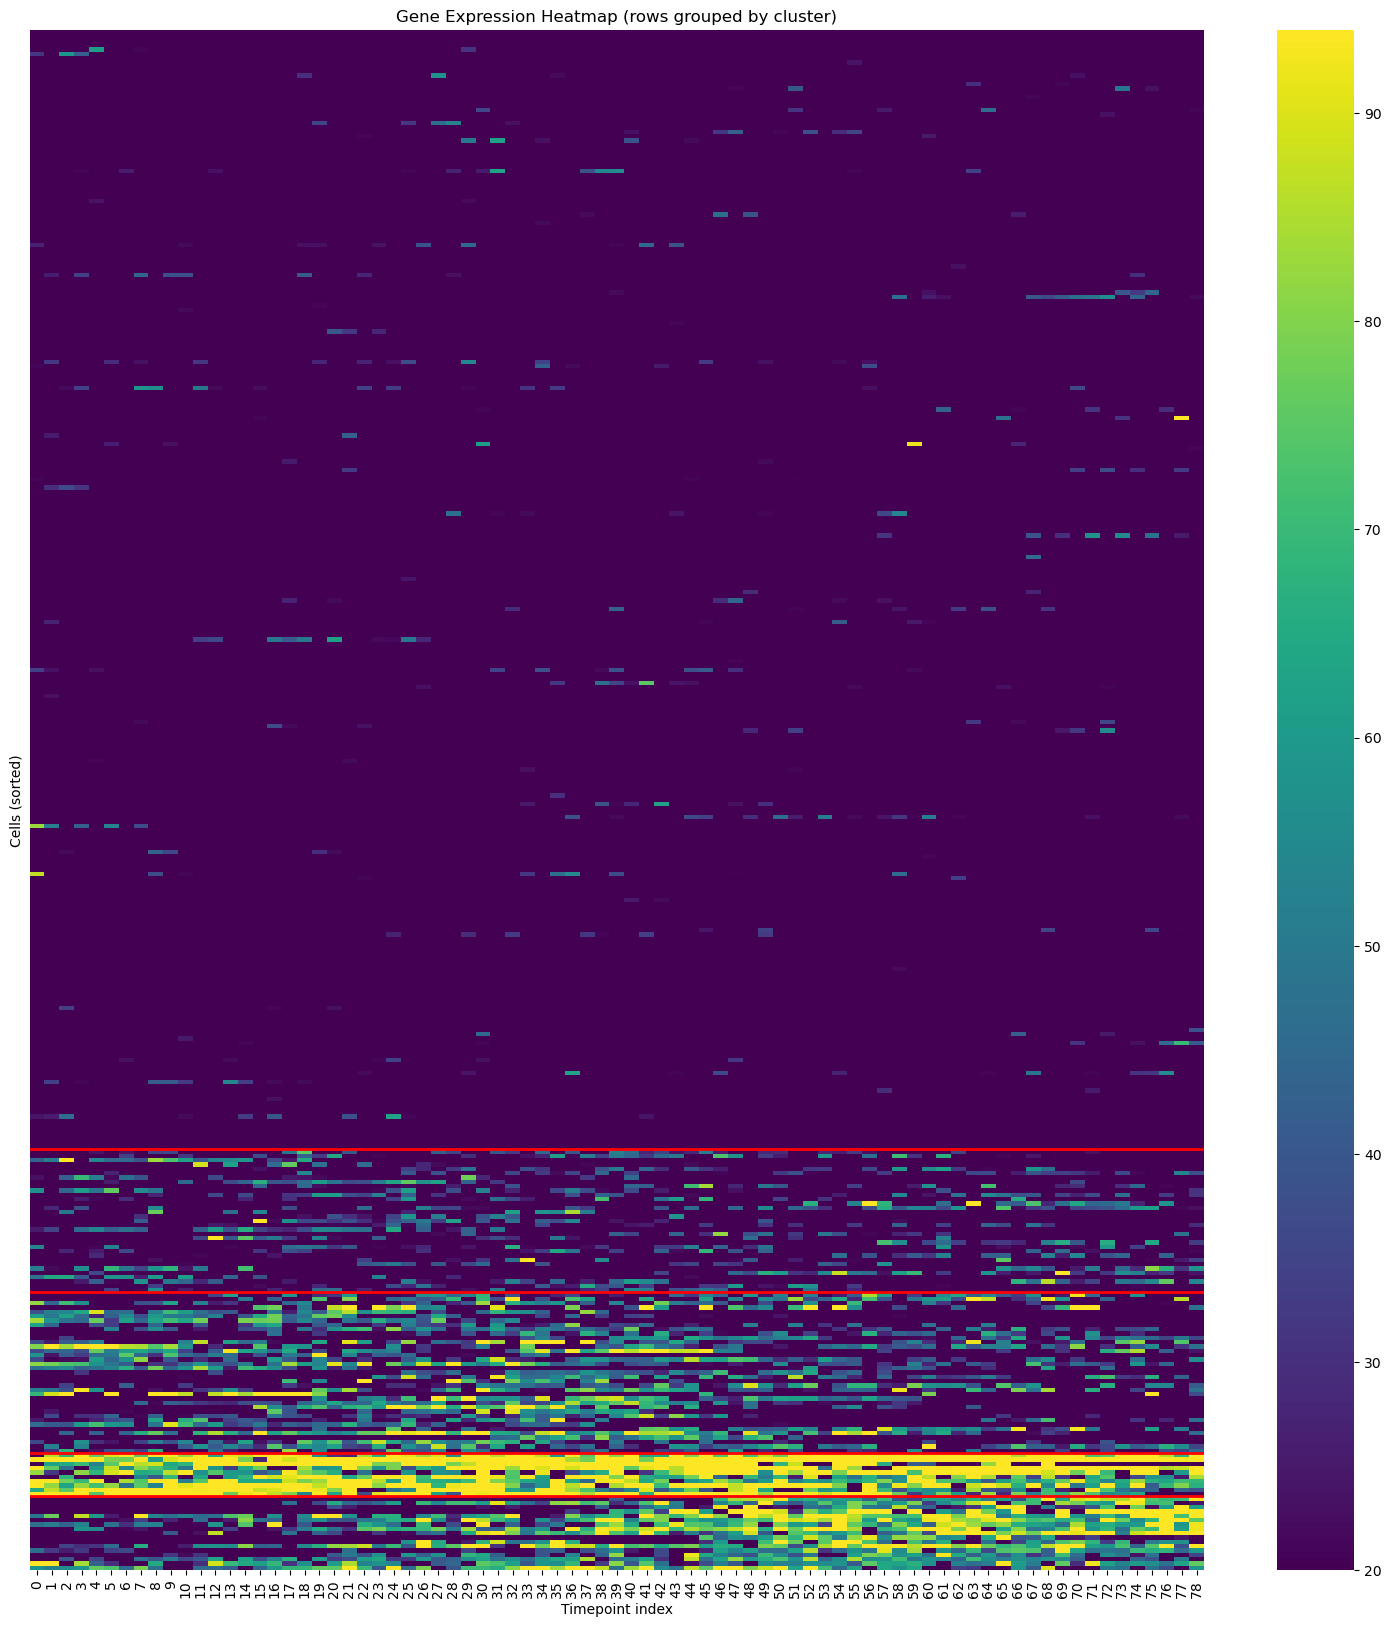

In [41]:
# ---- Heatmap sorted by KMeans cluster labels ----
# Row (cell) names in the same order used to build cells_array

clustered_cells_df = show_clustered_heat_map(labels_swapped, cells_array, cell_names, True, save_eps=True, filename="clustered_heatmap_swapped.eps")

In [42]:
uniform_rows, uniform_row_indices = get_uniform_rows(cells_array)
uniform_rows, uniform_row_indices

(array([[20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        ...,
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.]]),
 array([ 14,  15,  17,  18,  19,  20,  21,  22,  23,  25,  33,  37,  49,
         57,  58,  59,  60,  61,  63,  64,  65,  66,  68,  72,  73,  74,
         75,  86,  92,  94,  95,  96,  97,  98,  99, 100, 101, 103, 104,
        105, 106, 109, 110, 111, 112, 113, 117, 124, 127, 129, 134, 136,
        139, 142, 147, 149, 151, 159, 164, 166, 170, 173, 181, 183, 185,
        186, 187, 190, 192, 193, 196, 199, 200, 201, 202, 205, 211, 212,
        213, 214, 215, 217, 219, 223, 224, 225, 226, 227, 231, 232, 233,
        235, 237, 238, 240, 242, 244, 245, 246, 247, 248, 249, 250, 253,
        254, 256, 257, 259, 260, 261, 262, 263, 264, 267, 268, 269, 271,
        275, 276, 280, 283, 284, 286, 289, 290, 291, 292, 

In [43]:
labels_seperate_non_active = labels_swapped.copy()
labels_seperate_non_active[uniform_row_indices] = -1  # Change to cluster

In [44]:
labels_seperate_non_active = labels_seperate_non_active + 1

In [45]:
np.unique(labels_seperate_non_active)

array([0, 1, 2, 3, 4, 5])

C:\Users\97254\AppData\Local\Temp\ipykernel_17940\2358781790.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Figure saved as gRNA2_12.03.25-st-13-II_clustered_heatmap_seperate_non_active_6_clusters_v2.eps


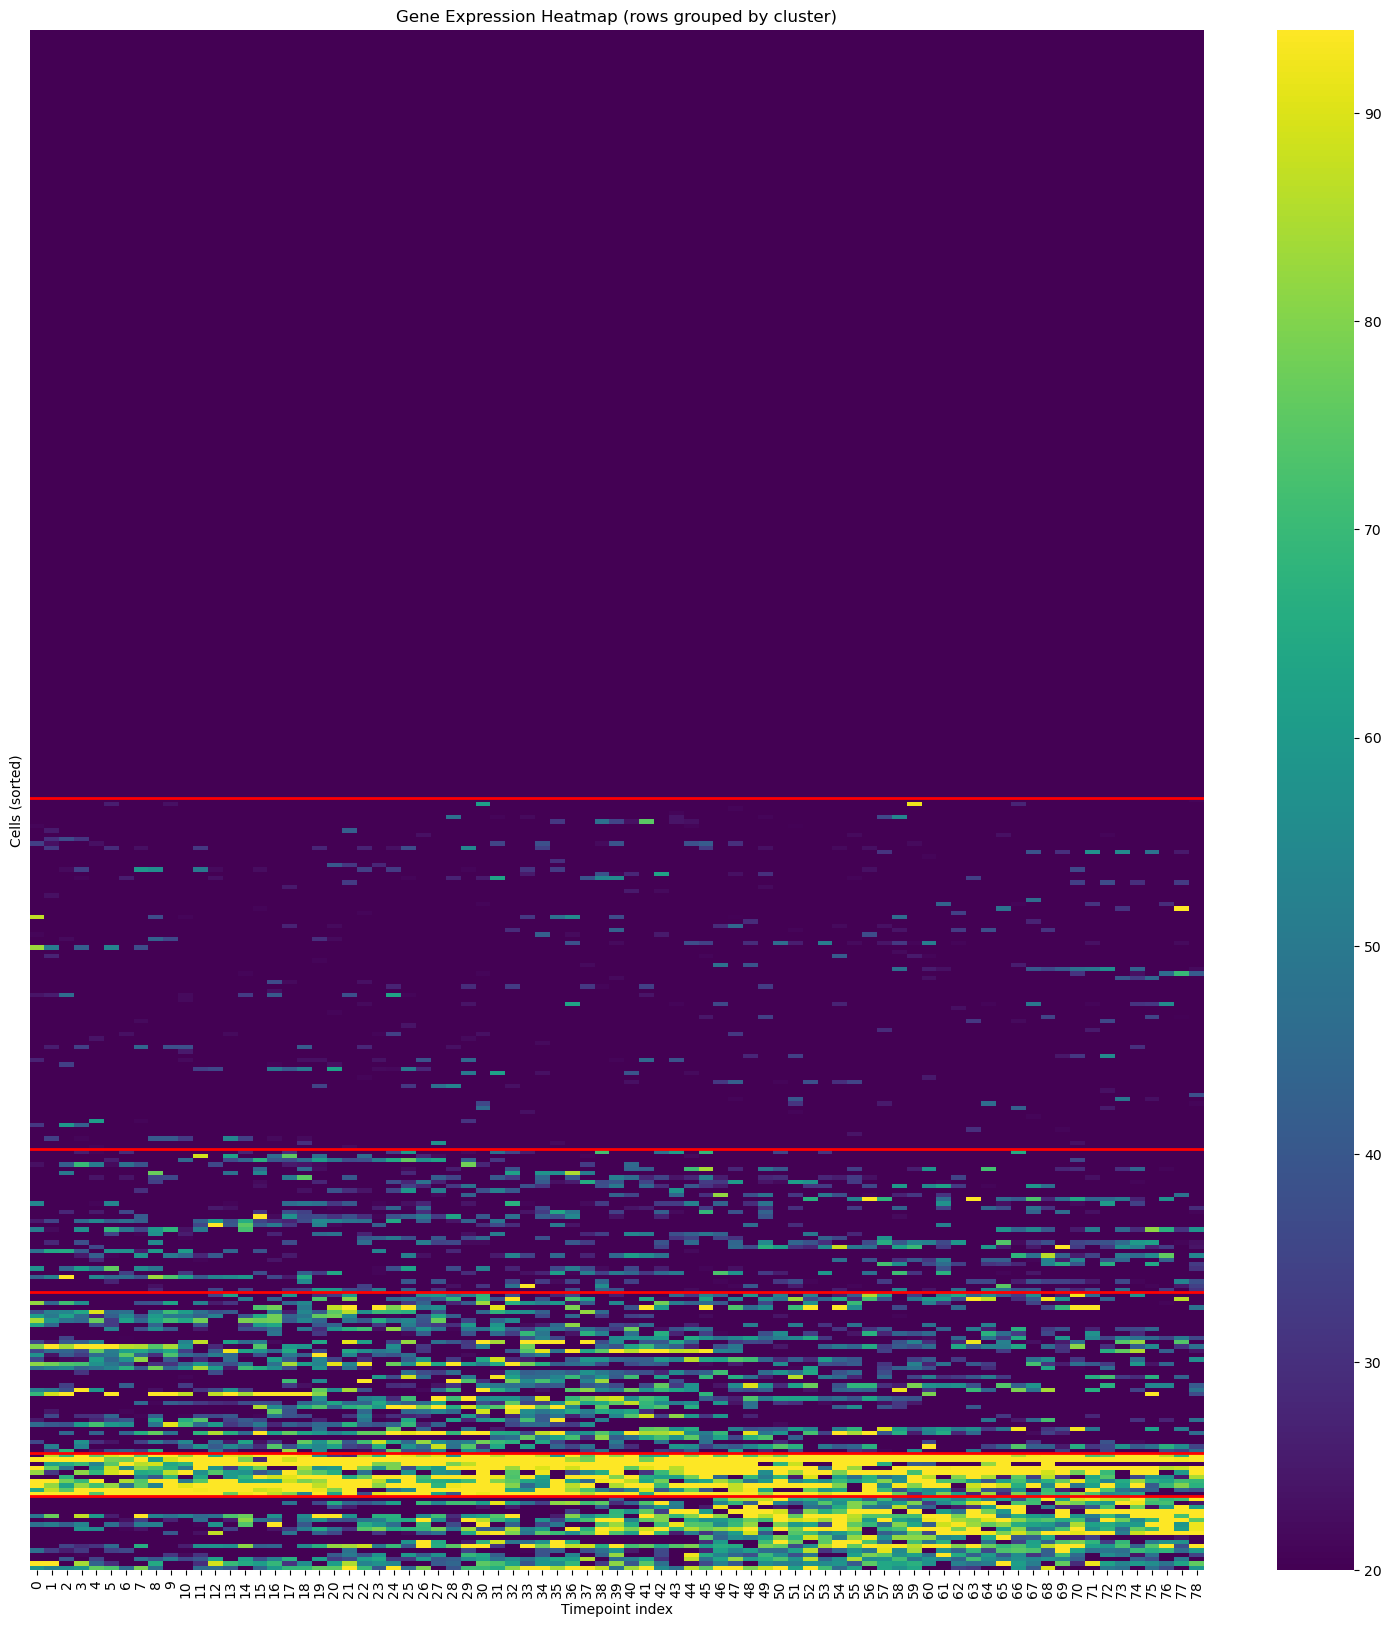

In [46]:
clustered_cells_df_seperate_non_active = show_clustered_heat_map(labels_seperate_non_active, cells_array, cell_names, True, save_eps=True, filename=f"{video_name}_clustered_heatmap_seperate_non_active_6_clusters_v2.eps")

In [ ]:
clustered_cells_df_seperate_non_active.to_csv(f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\outputs\\gRNA2\\{video_name}\\v3p3\\gene_expression_clustered_cells_df_seperate_non_active_5_clusters_v3p3_noise_20.csv', index=False)

#### Visualization

In [ ]:
cells_z_project_path = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\data\\gRNA2\\{video_name}\\SUM_C2-{video_name}.tif'

In [ ]:
cells_z_project =  tifffile.imread(cells_z_project_path)

In [ ]:
ms2_channel_z_projection_path = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\data\\gRNA2\\{video_name}\\SUM_C1-{video_name}.tif'

In [ ]:
ms2_channel_z_projection = tifffile.imread(ms2_channel_z_projection_path)

In [ ]:
ms2_channel_z_projection.shape

In [ ]:
np.unique(arr)

In [ ]:
short_burst_cluster_df = clustered_cells_df_seperate_non_active_tertiary[clustered_cells_df_seperate_non_active_tertiary['cluster'] == 2]

In [ ]:
noisey_cells_cluster_df =  clustered_cells_df_seperate_non_active_tertiary[clustered_cells_df_seperate_non_active_tertiary['cluster'] == 1]

In [ ]:
figures = []
for timepoint in range(ms2_channel_z_projection.shape[0]):
    ms2_img = enhance_cell_image_contrast(ms2_channel_z_projection[timepoint])
    enhanced_img = enhance_cell_image_contrast(cells_z_project[timepoint])
    masks_t = np.load(masks_paths[timepoint])['masks']
    overlay_img, cluster_colors, cluster_labels = cluster_mask_overlay(
        masks=masks_t,
        clustered_cells_df=clustered_cells_df_seperate_non_active,
        tracklets=tracklets,
        timepoint=timepoint,
        rng_seed=42,
        base_image=None,
        overlay_alpha=0.6,
        background_color=(0, 0, 0),
        out_dtype=np.uint8,
        cluster_name_map={
            0: "silent cells",
            1:"short burst  / noise",
            2:"weakly active",
            3:"moderate active",
            4:"high active"
        },
        fixed_colors={
            0:(64,64,64),      # gray
            1:(255,0,0),
            2:(255,165,0),
            3:(255,255,0),
            4:(255,255,255)
        })
    fig = plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(overlay_img, -1))
    plt.axis('off')
    plt.title(f"Cluster at timepoint {timepoint}")
    # Legend
    def _to_rgb01(c):
        c = np.asarray(c, dtype=float).ravel()
        if c.max() > 1.0:
            c = c / 255.0
        return tuple(np.clip(c, 0.0, 1.0))
    handles = [
        Patch(facecolor=_to_rgb01(c), edgecolor='black',
          label=f"{cluster_labels[cid]}")
    for cid, c in cluster_colors.items()]
    plt.legend(handles=handles, loc='upper right', fontsize=6)
    plt.tight_layout()
    figures.append(fig)
    if timepoint == 1:
        plt.savefig(f'cell_cluster_{video_name}.eps', format='eps', bbox_inches='tight', dpi=300)
        plt.savefig(f'cell_cluster_{video_name}.png', dpi=300)
    plt.close(fig)
# Save as GIF
create_gif_from_figures(figures[:-1],f'mask_overlay_clustering_{video_name}_v3p3.gif', fps=1)

In [ ]:
cluster_labels

In [ ]:
cluster_colors

In [ ]:
cluster_colors_rgb = {cid: tuple(np.array(c)/255.0) for cid, c in cluster_colors.items()}

In [ ]:
fixed_colors = {
    0: (64/255, 64/255, 64/255),   # dark gray
    1: (1.0, 1.0, 1.0),            # white
    2: (1.0, 1.0, 0.0),            # yellow
    3: (1.0, 0.0, 0.0),            # red
}

plt.figure(figsize=(6,6))
for cid in sorted(cluster_labels.keys()):
    mask = labels == cid
    if not np.any(mask):
        continue
    # Use edgecolor for visibility (especially white)
    plt.scatter(
        Z[mask, 0],
        Z[mask, 1],
        s=12,
        c=[cluster_colors_rgb.get(cid, (0.5,0.5,0.5))],
        label=cluster_labels[cid],
        edgecolors='black',
        linewidths=0.4
    )

plt.title("KMeans Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clusters", fontsize=6)
plt.tight_layout()
plt.show()